In [47]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd
import sys
import os
from tqdm.notebook import tqdm  # Progress bars
import os
import re
from typing import List, Dict

In [43]:
# Configuration
PARENT_DIR = r"M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald"
RASTER_PATTERN = "*multispec_ortho_100cm.tif"

In [37]:
# Band Information Table
def display_band_info():
    band_data = {
        "Band Number": ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10"],
        "Band Name": ["Coastal Blue", "Blue", "Green-531", "Green", "Red-650", "Red", "Red Edge-705", "Red Edge-717", "Red Edge-740", "NIR"],
        "Wavelength (nm)": [444, 475, 531, 560, 650, 668, 705, 717, 740, 842],
        "Bandwidth (nm)": [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]
    }
    band_table = pd.DataFrame(band_data)
    return band_table

display_band_info()

,Band Number,Band Name,Wavelength (nm),Bandwidth (nm)
0,B1,Coastal Blue,444,28
1,B2,Blue,475,32
2,B3,Green-531,531,14
3,B4,Green,560,27
4,B5,Red-650,650,16
5,B6,Red,668,14
6,B7,Red Edge-705,705,10
7,B8,Red Edge-717,717,12
8,B9,Red Edge-740,740,18
9,B10,NIR,842,57


Find Multispectral rasterfiles


In [52]:

def find_raster_files(parent_dir: str) -> List[Dict]:
    """
    Find all multispec ortho files in export folders with metadata.
    
    Args:
        parent_dir: Root directory containing project folders
        
    Returns:
        List of dictionaries with:
        - 'path': Full file path
        - 'date': Extracted date (YYYYMMDD)
        - 'site': Extracted site name
        - 'filename': Base filename
    """
    matches = []
    
    for root, dirs, files in os.walk(parent_dir):
        # Only search in 'exports' folders
        if "exports" not in root.split(os.sep):
            continue
            
        for file in files:
            # Case-insensitive search for the key pattern
            if (file.lower().endswith(".tif") and 
                "multispec_ortho_100" in file.lower()):
                
                full_path = os.path.join(root, file)
                
                # Extract metadata from path
                path_parts = full_path.split(os.sep)
                try:
                    # Get date (assuming format: .../20240823/...)
                    date = next(p for p in path_parts if p.isdigit() and len(p) == 8)
                    # Get site name (assuming format: .../Pfynwald/...)
                    site = path_parts[path_parts.index("Upscale_Metashapeprojects") + 1]
                except (StopIteration, ValueError):
                    date = "unknown_date"
                    site = "unknown_site"
                
                matches.append({
                    "path": full_path,
                    "date": date,
                    "site": site,
                    "filename": file
                })
    
    # Sort by date then by site
    return sorted(matches, key=lambda x: (x["date"], x["site"]))


In [53]:
raster_files = find_raster_files(PARENT_DIR)

# Display results
print(f"Found {len(raster_files)} files:")
for file in raster_files:
    print(f"{file['date']} | {file['site']} | {file['filename']}")

Found 5 files:
20240823 | Pfynwald | 20240823_Pfynwald_multispec_ortho_100cm.tif
20240925 | Pfynwald | 20240925_Pfynwald_multispec_ortho_100cm.tif
20241024 | Pfynwald | 20241024_Pfynwald_multispec_ortho_100cm.tif
20241127 | Pfynwald | 20241127_Pfynwald_multispec_ortho_100cm.tif
20241216 | Pfynwald | 20241216_Pfynwald_multispec_ortho_100cm.tif


In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)  # Cache results to avoid reloading
def load_and_preprocess_raster(filepath):
    """Load raster, extract metadata, and preprocess bands."""
    with rasterio.open(filepath) as src:
        bands = src.read()
        profile = src.profile
    
    # Extract date from path (assuming format: .../20240823/...)
    date = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    
    # Preprocess (same as your existing pipeline)
    bands = np.where(bands == 65535, np.nan, bands)  # NA handling
    bands = bands / 32768 if np.nanmax(bands) > 1.0 else bands  # Reflectance scaling
    
    return {
        "bands": bands,
        "profile": profile,
        "date": date,
        "filepath": filepath
    }

# Load all rasters (cached after first load)
raster_data = [load_and_preprocess_raster(p) for p in tqdm(raster_paths)]

In [32]:
# Function to load a multiband raster file
def load_raster(filepath):
    with rasterio.open(filepath) as src:
        bands = src.read()
        profile = src.profile
    print("Loaded bands in order:")
    for i, name in enumerate(display_band_info()["Band Name"], start=1):
        print(f"Band {i}: {name}")
    return bands, profile

# Function to assign NA values
def assign_na_values(bands, na_value=65535):
    bands = np.where(bands == na_value, np.nan, bands)
    return bands

# Function to scale bands to reflectance values if needed
def scale_to_reflectance(bands):
    return bands / 32768

# Function to check if values are reflectance values and scale if necessary
def check_reflectance(bands):
    if np.max(bands) > 1.0:
        print("Warning: Values exceed 1.0, scaling to reflectance values.")
        return scale_to_reflectance(bands)
    else:
        print("Values appear to be reflectance values.")
        return bands

# Function to calculate NDVI (Normalized Difference Vegetation Index)
def calculate_ndvi(nir_band, red_band):
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)  # Avoid division by zero
    return ndvi

# Function to calculate PRI (Photochemical Reflectance Index)
def calculate_pri(band531, band570):
    pri = (band531 - band570) / (band531 + band570 + 1e-10)  # Avoid division by zero
    return pri


# Function to visualize a single-band raster
def visualize_raster(
    data, 
    title="Raster Index",
    cmap="RdYlGn",
    percentile_stretch=(2, 98),
    band_info=None,
    formula=None,
    index_name=None
):
    """
    Visualize a raster with dynamic scaling, band info, and formula annotation.
    Fixes title/subtitle overlap using suptitle() and adjusted padding.
    """
    # Calculate dynamic range
    vmin, vmax = np.nanpercentile(data, percentile_stretch)

    # Create figure with adjusted height to accommodate titles
    fig, ax = plt.subplots(figsize=(10, 8))  # Increased height to 8 (from 7)
    img = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Colorbar
    cbar = fig.colorbar(img, ax=ax, label=f"{index_name} Value" if index_name else 'Value', extend="both")
    
    # Main title (using suptitle for better control)
    fig.suptitle(title, fontsize=14, y=0.92)  # y-position adjusted
    
    # Subtitle with band info and formula
    subtitle_parts = []
    if band_info:
        bands_str = ", ".join([f"{name} (Band {num})" for name, num in band_info.items()])
        subtitle_parts.append(f"Bands: {bands_str}")
    if formula:
        subtitle_parts.append(f"Formula: {formula}")
    
    if subtitle_parts:
        subtitle = "\n".join(subtitle_parts)
        ax.set_title(
            subtitle,
            fontsize=10,
            pad=20,  # Increased padding between title and subtitle
            loc='center',
            style='italic',
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=5)
        )
    
    ax.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust top boundary to 90%
    plt.show()

Site: Pfynwald
date: 20240823
Loaded bands in order:
Band 1: Coastal Blue
Band 2: Blue
Band 3: Green-531
Band 4: Green
Band 5: Red-650
Band 6: Red
Band 7: Red Edge-705
Band 8: Red Edge-717
Band 9: Red Edge-740
Band 10: NIR
Values appear to be reflectance values.


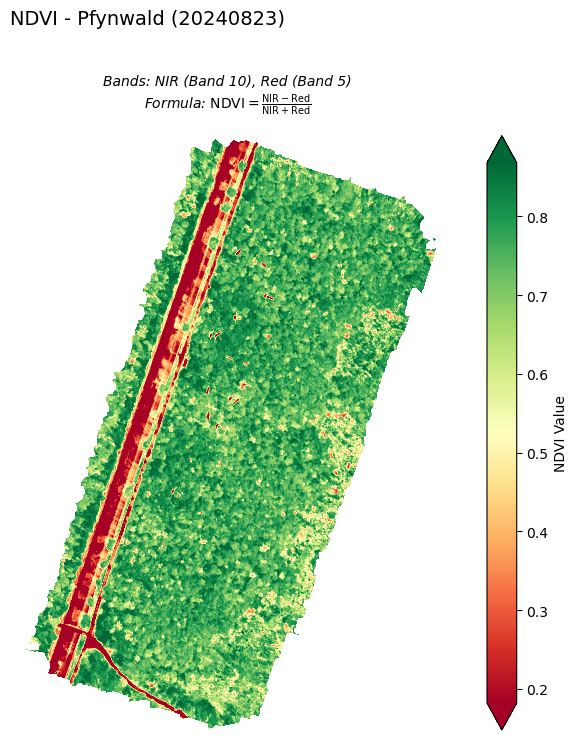

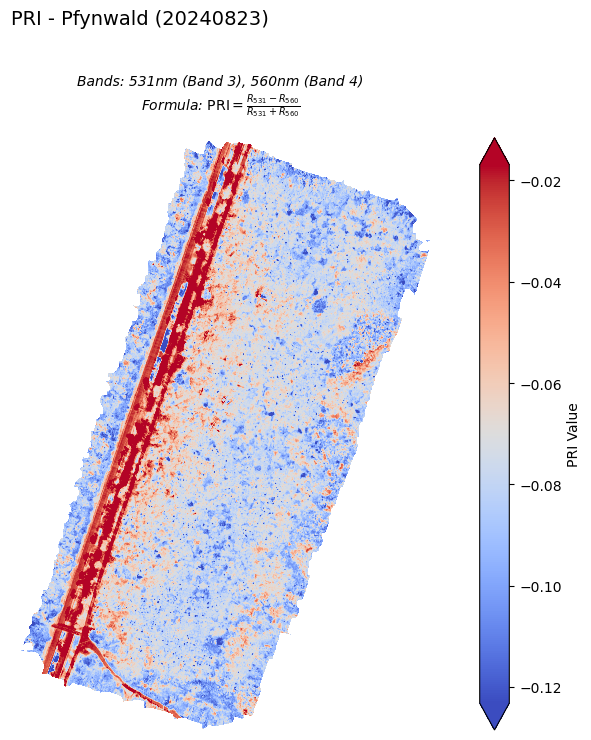

In [33]:


# Example usage:
# Uncomment the following lines to run in Jupyter Notebook
filepath = r"M:\working_package_2\2024_dronecampaign\02_processing\metashape_projects\Upscale_Metashapeprojects\Pfynwald\20240823\exports\20240823_Pfynwald_multispec_ortho_100cm.tif"

# Extract site and name from the file path

date = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
site = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(filepath))))


print(f"Site: {site}")
print(f"date: {date}")

bands, profile = load_raster(filepath)
bands = assign_na_values(bands)
bands = check_reflectance(bands)


ndvi_result = calculate_ndvi(bands[9], bands[4])

visualize_raster(
    data=ndvi_result,
    title=f"NDVI - {site} ({date})",
    cmap="RdYlGn",
    percentile_stretch=(5, 95),
    band_info={"NIR": 10, "Red": 5},
    formula=r"$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$",
    index_name="NDVI"
)

#Assuming PRI uses Green-531 (band 3) and a missing 570nm band (which is subsituted with band 4)
pri_result = calculate_pri(bands[2], bands[3])  # Assuming Band 3=531nm, Band 4=560nm

visualize_raster(
    data=pri_result,
    title=f"PRI - {site} ({date})",
    cmap="coolwarm",
    percentile_stretch=(10, 90),
    band_info={"531nm": 3, "560nm": 4},
    formula=r"$\text{PRI} = \frac{R_{531} - R_{560}}{R_{531} + R_{560}}$",
    index_name="PRI"
)